In [15]:
from time import time
import pickle
import pandas as pd
import numpy as np
import feather as ft
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from jupyter_contrib_nbextensions.application import main

# library import for gradient boosting classifier
from sklearn import ensemble


## Import up sound alert dependencies
## and play Rick and Morty clip after long cell runs
from IPython.display import Audio, display
def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
#allDone()

#%matplotlib



In [38]:
##for MLP hyperparameter optimization
##parameter space argument calls adam - but SGD should be tested
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameter_space = {
    'hidden_layer_sizes': [(30,),(45,),(25,12),(25,25,12)],
    'solver': ['sgd','adam'],
    'nesterovs_momentum': [True],
    'momentum': [.01,0.1,.5,.9],
    'alpha': [0.0001,.01],
    'learning_rate': ['adaptive'],
    'learning_rate_init':[.001],
    'activation':['tanh','logistic','relu'],
    'batch_size':['auto',50,500,5000]
}

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
#for running randomized subsample
n_iter_search = 50            
            
# run grid search and start the timer
clf = RandomizedSearchCV(mlp, parameter_space,  n_iter=n_iter_search, n_jobs=-3, cv=3)
start = time()
clf.fit(X_train,y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf.cv_results_['params'])))
report(clf.cv_results_,10)

allDone()

#with open("RandomizedSearchCV03162019.txt", "w") as text_file:
#    print(clf.cv_results_)

RandomizedSearchCV took 350.55 seconds for 50 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.970 (std: 0.003)
Parameters: {'solver': 'adam', 'nesterovs_momentum': True, 'momentum': 0.1, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (45,), 'batch_size': 50, 'alpha': 0.01, 'activation': 'relu'}

Model with rank: 2
Mean validation score: 0.970 (std: 0.002)
Parameters: {'solver': 'adam', 'nesterovs_momentum': True, 'momentum': 0.01, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (25, 25, 12), 'batch_size': 50, 'alpha': 0.01, 'activation': 'relu'}

Model with rank: 3
Mean validation score: 0.970 (std: 0.003)
Parameters: {'solver': 'adam', 'nesterovs_momentum': True, 'momentum': 0.1, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (25, 25, 12), 'batch_size': 50, 'alpha': 0.01, 'activation': 'tanh'}

Model with rank: 4
Mean validation score: 0.969 (std: 0.002)
Paramete

In [12]:
#create a time-stamp string for pickling models after fitting
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

In [3]:
#uses the feather library to import large training dataset from R
x=pd.read_feather("C:\\Users\\Vicki\\Desktop\\x.feather")
x1=pd.read_feather("C:\\Users\\Vicki\\Desktop\\faulty_training.feather")
x.faultNumber=x.faultNumber.astype(int)
x.faultNumber.dtype
x1.faultNumber=x1.faultNumber.astype(int)
x1.faultNumber.dtype
#xc is a combination of the fault_free and faulty training sets from R
xc=x.append(x1)
xc.rename(columns={'sample':'SAMPLE'}, 
                 inplace=True)


C:\Users\vicki\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
#repeat with feather to load the separated testing datasets
xt1=pd.read_feather("C:\\Users\\Vicki\Desktop\\f_free_test.feather")
xt2=pd.read_feather("C:\\Users\\Vicki\Desktop\\faulty_test.feather")
xt1.faultNumber.dtype
#combines the testing sets
xc2=xt1.append(xt2)
xc2.rename(columns={'sample':'SAMPLE'}, 
                 inplace=True)


In [5]:
#confirms merge of faulty and fault_free training sets
print(xc.faultNumber.unique())
print(xc2.faultNumber.unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [6]:
feature_cols = x.columns[3:55]

In [7]:
#pares down the combined training set to faults of interest
#faults=[0,2,3,5,10,13,14] fault 3 disabled because it is unmeasured
faults=[0,2,5,10,13,14]
samples=list(range(495,500))
xc_pare=xc[xc.faultNumber.isin(faults)]
xc_pare=xc_pare[xc_pare.SAMPLE.isin(samples)]
xc2_pare=xc2[xc2.faultNumber.isin(faults)]
xc2_pare=xc2_pare[xc2_pare.SAMPLE.isin(samples)]


#selects only the feature_cols
X=xc_pare.loc[:,feature_cols]
X2=xc2_pare.loc[:,feature_cols]

In [8]:
y_train=xc_pare.faultNumber
y_test=xc2_pare.faultNumber

In [9]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X)
X_test=scaler.transform(X2)

In [10]:
print(X_train.shape)
y_train.shape

(15000, 52)


(15000,)

In [39]:
mlp=MLPClassifier(activation='relu', alpha=0.01, batch_size=50, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(45,), learning_rate='adaptive',
       learning_rate_init=.001, max_iter=400, momentum=0.1,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [42]:
##fit the neural network to training data
mlp.fit(X_train,y_train)
allDone()

take1=mlp.score(X_test,y_test)
print(take1)
y_pred=mlp.predict(X_test)
conf=confusion_matrix(y_test,y_pred,labels=xc_pare.faultNumber.unique())
classes=xc_pare.faultNumber.unique()

##pickle the model for later testing
#create a time-stamp string for pickling models after fitting
timestr = time.strftime("%Y%m%d-%H%M%S")
filename='good'+timestr+'.sav'
pickle.dump(mlp,open(filename,'wb'))

##-----------------------------------------##
##code snippet below ripped from internet##
#mlp = pickle.load(open('20190316-103639.sav', 'rb'))
#result = loaded_model.score(X_test, y_test)
#print(result)

0.9794


In [18]:
##cell for defining and fitting GBT classifier
# Fit classifier with out-of-bag estimates
params = {'n_estimators': 3000, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
gbt = ensemble.GradientBoostingClassifier(**params)

gbt.fit(X_train, y_train)
acc = gbt.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

allDone()

Accuracy: 0.9669


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameter_space = {
    'n_estimators': [50,100,200,300,400,500,600,700,800,900,1000],
    'max_depth': [3],
    'subsample': [.5],
    'learning_rate': [.01],
    'min_samples_leaf':[1],
    'random_state':[3]
}

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
#for running randomized subsample
n_iter_search = 11            
            
# run grid search and start the timer
clf = RandomizedSearchCV(gbt, parameter_space,  n_iter=n_iter_search, n_jobs=-1, cv=3)
start = time()
clf.fit(X_train,y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(clf.cv_results_['params'])))
report(clf.cv_results_,10)

allDone()

RandomizedSearchCV took 552.68 seconds for 11 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.957 (std: 0.003)
Parameters: {'subsample': 0.5, 'random_state': 3, 'n_estimators': 1000, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.957 (std: 0.002)
Parameters: {'subsample': 0.5, 'random_state': 3, 'n_estimators': 900, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}

Model with rank: 3
Mean validation score: 0.956 (std: 0.002)
Parameters: {'subsample': 0.5, 'random_state': 3, 'n_estimators': 800, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}

Model with rank: 4
Mean validation score: 0.955 (std: 0.002)
Parameters: {'subsample': 0.5, 'random_state': 3, 'n_estimators': 700, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.01}

Model with rank: 5
Mean validation score: 0.954 (std: 0.002)
Parameters: {'subsample': 0.5, 'random_state': 3, 'n_estimators': 600, 'min_sample

In [30]:
##imports and fits support vector machine to training data
##displays accuracy score for test set
from sklearn.svm import SVC
clf = SVC(gamma=.1)
clf.fit(X_train, y_train)


print(clf.score(X_test,y_test))
allDone()

0.89


In [19]:
take1_best=gbt.score(X_test,y_test)
print(take1_best)
y_pred=gbt.predict(X_test)
conf=confusion_matrix(y_test,y_pred,labels=xc_pare.faultNumber.unique())
classes=xc_pare.faultNumber.unique()
print(conf)

0.9668666666666667
[[2410    0    0   90    0    0]
 [   0 2500    0    0    0    0]
 [   0    0 2499    1    0    0]
 [ 317    0    0 2174    9    0]
 [   4    0    0   75 2421    0]
 [   1    0    0    0    0 2499]]


In [20]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = xc_pare.faultNumber.unique()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[2410    0    0   90    0    0]
 [   0 2500    0    0    0    0]
 [   0    0 2499    1    0    0]
 [ 317    0    0 2174    9    0]
 [   4    0    0   75 2421    0]
 [   1    0    0    0    0 2499]]


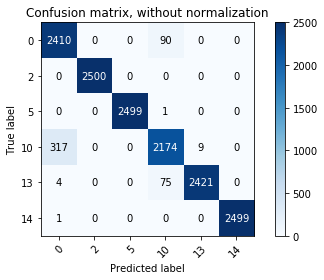

In [21]:
plot_confusion_matrix(y_test,y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues)

AxesSubplot(0.125,0.125;0.775x0.755)


AttributeError: 'SVC' object has no attribute 'loss_curve_'

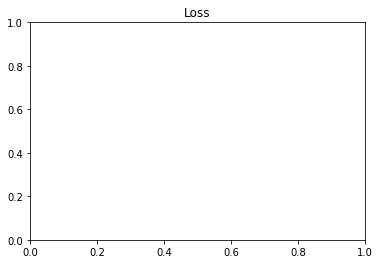

In [33]:
fig, ax = plt.subplots()
ax.set_title("Loss")
print(ax)
ax.plot(clf.loss_curve_)